# Bank Marketing Study - Assignment 3

In [1]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# import base packages into the namespace for this program
import numpy as np
import pandas as pd

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from math import sqrt  # for root mean-squared error calculation
import seaborn as sns  # pretty plotting, including heat map
import matplotlib.pyplot as plt  # static plotting
plt.style.use('fivethirtyeight')

In [2]:
# read data for the Boston Housing Study
# creating data frame 
bank_input = pd.read_csv('bank.csv', sep=";")

## EDA

In [3]:
bank_input.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
bank_input.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [5]:
bank_input.astype('object').describe()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,67,12,3,4,2,2353,2,2,3,31,12,875,32,292,24,4,2
top,34,management,married,secondary,no,0,yes,no,cellular,20,may,123,1,-1,0,unknown,no
freq,231,969,2797,2306,4445,357,2559,3830,2896,257,1398,27,1734,3705,3705,3705,4000


### Target Exploration

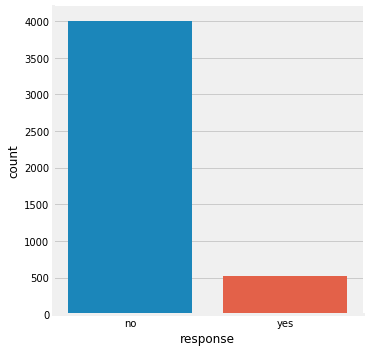

In [6]:
sns.catplot(x="response", kind="count", data=bank_input)

The target is unbalanced with the majority of clinets not subscribing to a term deposit.  The values are yes/no and should be converted to 0/1 for modeling.

In [7]:
# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

# define binary variable for having credit in default
bank_input['default'] = bank_input['default'].map(convert_to_binary)

# define binary variable for having a mortgage or housing loan
bank_input['housing'] = bank_input['housing'].map(convert_to_binary)

# define binary variable for having a personal loan
bank_input['loan'] = bank_input['loan'].map(convert_to_binary)

# define response variable to use in the model
bank_input['response'] = bank_input['response'].map(convert_to_binary)

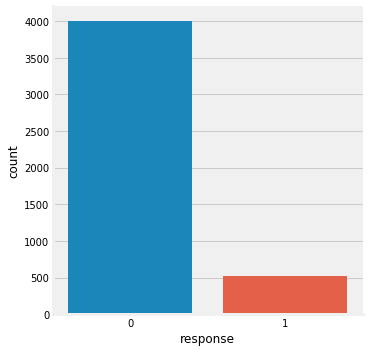

In [8]:
sns.catplot(x="response", kind="count", data=bank_input)

### Missing Value Analysis

In [9]:
total = bank_input.isnull().sum().sort_values(ascending=False)
percent = (bank_input.isnull().sum()/bank_input.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,join='outer', keys=['Total Missing Count', '% of Total Observations'])
missing_data.index.name ='Feature'

missing_data

,Total Missing Count,% of Total Observations
Feature,,
response,0,0.0
loan,0,0.0
job,0,0.0
marital,0,0.0
education,0,0.0
default,0,0.0
balance,0,0.0
housing,0,0.0
contact,0,0.0


No data is missing so no imputation or data cleaning in regards to missing data will be required.

### Variable Exploration

As seen above much of the data is categorical in nature and will need to be converted to numerics using one-hot encoding, this will be done before exploring the variables.

In [10]:
# Get one hot encoding of columns
one_hot = pd.get_dummies(bank_input[['job', 'marital', 'education', 'contact', 'month', 'poutcome']])
# Drop columns as they now encoded
bank_input = bank_input.drop(['job', 'marital', 'education', 'contact', 'month', 'poutcome'],axis = 1)
# Join the encoded df
bank_input = bank_input.join(one_hot)

In [11]:
bank_input.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,0,0,19,79,1,-1,0,...,0,0,0,0,1,0,0,0,0,1
1,33,0,4789,1,1,11,220,1,339,4,...,0,0,1,0,0,0,1,0,0,0
2,35,0,1350,1,0,16,185,1,330,1,...,0,0,0,0,0,0,1,0,0,0
3,30,0,1476,1,1,3,199,4,-1,0,...,1,0,0,0,0,0,0,0,0,1
4,59,0,0,1,0,5,226,1,-1,0,...,0,0,1,0,0,0,0,0,0,1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


<Figure size 432x288 with 0 Axes>

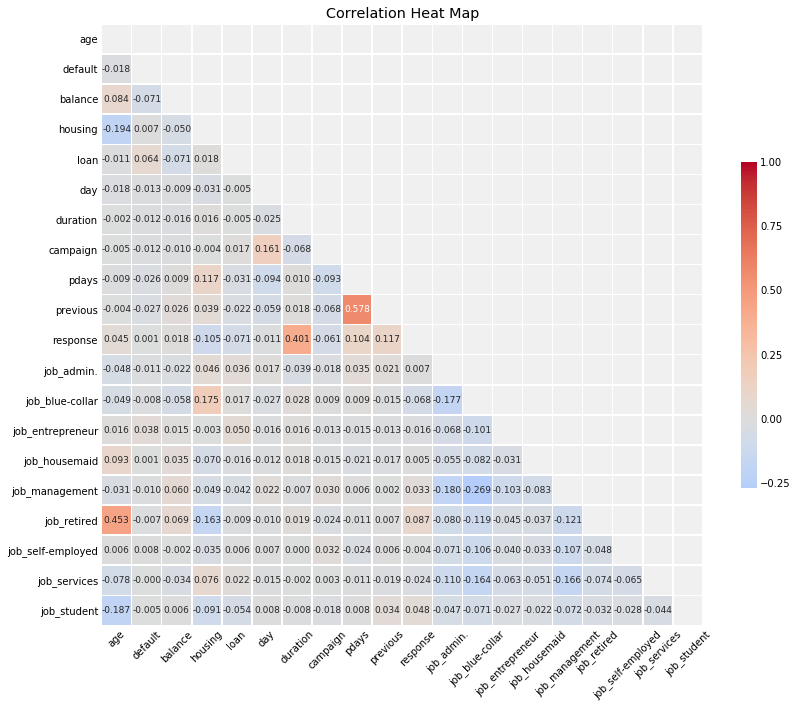

In [12]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      


corr_chart(df_corr = bank_input.iloc[:,0:20])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


<Figure size 432x288 with 0 Axes>

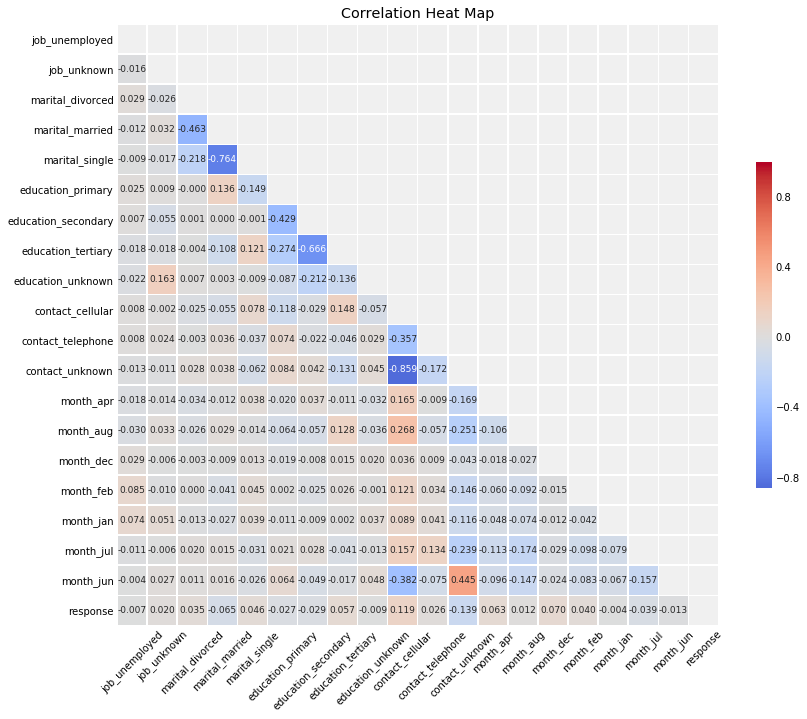

In [13]:
cols = bank_input.columns.values[21:40]
cols = np.append(cols, [['response']])
corr_chart(df_corr = bank_input[cols])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


<Figure size 432x288 with 0 Axes>

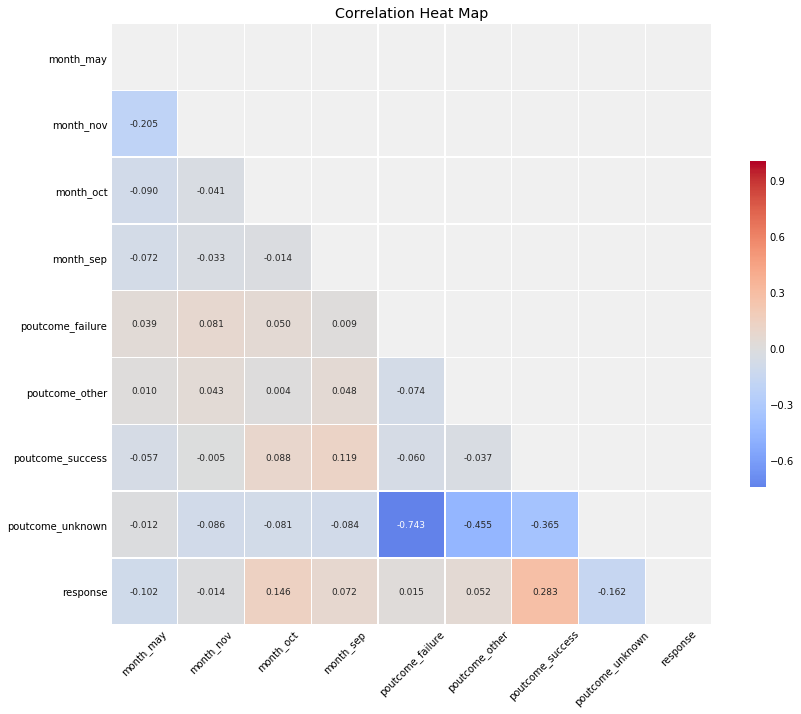

In [14]:
cols = bank_input.columns.values[41:49]
cols = np.append(cols, [['response']])
corr_chart(df_corr = bank_input[cols])

Duration is the most correlated with response which can be seen further in the box plot below.

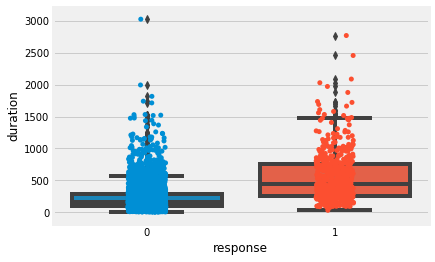

In [15]:
sns.boxplot(x="response", y="duration", data=bank_input)
sns.stripplot(x="response", y="duration", data=bank_input, jitter=True, edgecolor="gray")

## Feature Engineering

In [16]:
bank_input['BalanceDivDuration'] = bank_input['balance'] / bank_input['duration']
bank_input['BalanceTimesDefault'] = bank_input['balance'] * bank_input['default']
bank_input['pdaysTimeDuration'] = bank_input['pdays'] * bank_input['duration']
bank_input['hasTwoLoans'] = bank_input['housing'] * bank_input['loan']
bank_input['housingDefault'] = bank_input['housing'] * bank_input['default']
bank_input['loanDefault'] = bank_input['loan'] * bank_input['default']

## Model Development

In [17]:
# https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

### Baseline Model, No Engineered Features, Loan/Default/Housing only

In [18]:
X = bank_input[['loan', 'housing', 'default']]
y = bank_input['response']

logreg = LogisticRegression(solver='lbfgs')

scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
#print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
#print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average auc is 0.608


In [19]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()

scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(classifier, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(classifier, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
#print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
#print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average auc is 0.602


In [20]:
from sklearn.model_selection import cross_val_predict
predictions = pd.DataFrame({"logistic1":cross_val_predict(logreg, X, y, cv=10, method="predict_proba")[:,1], "bayes1":cross_val_predict(classifier, X, y, cv=10, method="predict_proba")[:,1]})
predictions.head()

,logistic1,bayes1
0,0.163914,0.201629
1,0.045903,0.005068
2,0.093276,0.114553
3,0.045903,0.005068
4,0.093276,0.114553


### Engineered Features, Loan/Default/Housing only

In [21]:
X = bank_input[['loan', 'housing', 'default', 'hasTwoLoans', 'housingDefault', 'loanDefault']]
y = bank_input['response']

logreg = LogisticRegression(solver='lbfgs')

scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
#print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
#print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average auc is 0.606


In [22]:
classifier = GaussianNB()

scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(classifier, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(classifier, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
#print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
#print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average auc is 0.605


In [23]:
predictions1 = pd.DataFrame({"logistic2":cross_val_predict(logreg, X, y, cv=10, method="predict_proba")[:,1], "bayes2":cross_val_predict(classifier, X, y, cv=10, method="predict_proba")[:,1]})
predictions = predictions.join(predictions1)
predictions.head()

,logistic1,bayes1,logistic2,bayes2
0,0.163914,0.201629,0.166938,0.378874
1,0.045903,0.005068,0.061887,0.000094
2,0.093276,0.114553,0.090899,0.238079
3,0.045903,0.005068,0.061887,0.000094
4,0.093276,0.114553,0.090899,0.238079


### All features

In [24]:
X = bank_input.drop('response',1)
y = bank_input['response']

logreg = LogisticRegression(solver='lbfgs', max_iter=4000)

scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
#print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
#print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average auc is 0.796


In [25]:
classifier = GaussianNB()

scores_accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(classifier, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(classifier, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
#print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
#print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average auc is 0.800


### Ensemble

In [26]:
from sklearn import metrics
def blend_models_predict(X):
    return ((cross_val_predict(logreg, X, y, cv=10, method="predict_proba")[:,1]) + (cross_val_predict(classifier, X, y, cv=10, method="predict_proba")[:,1]))/2

y_pred = blend_models_predict(X)

[fpr, tpr, thr] = roc_curve(y, y_pred)
print("Ensemble auc is %2.3f" % auc(fpr, tpr))


Ensemble auc is 0.820


In [27]:
predictions1 = pd.DataFrame({"ensemble":blend_models_predict(X), "logisticAll":cross_val_predict(logreg, X, y, cv=10, method="predict_proba")[:,1], "bayesAll":cross_val_predict(classifier, X, y, cv=10, method="predict_proba")[:,1], "actual":y})
predictions = predictions.join(predictions1)
predictions.head()

,logistic1,bayes1,logistic2,bayes2,ensemble,logisticAll,bayesAll,actual
0,0.163914,0.201629,0.166938,0.378874,0.056732,0.082854,0.030610,0
1,0.045903,0.005068,0.061887,0.000094,0.564209,0.232821,0.895596,0
2,0.093276,0.114553,0.090899,0.238079,0.558711,0.181820,0.935602,0
3,0.045903,0.005068,0.061887,0.000094,0.074529,0.052218,0.096839,0
4,0.093276,0.114553,0.090899,0.238079,0.106246,0.052219,0.160274,0


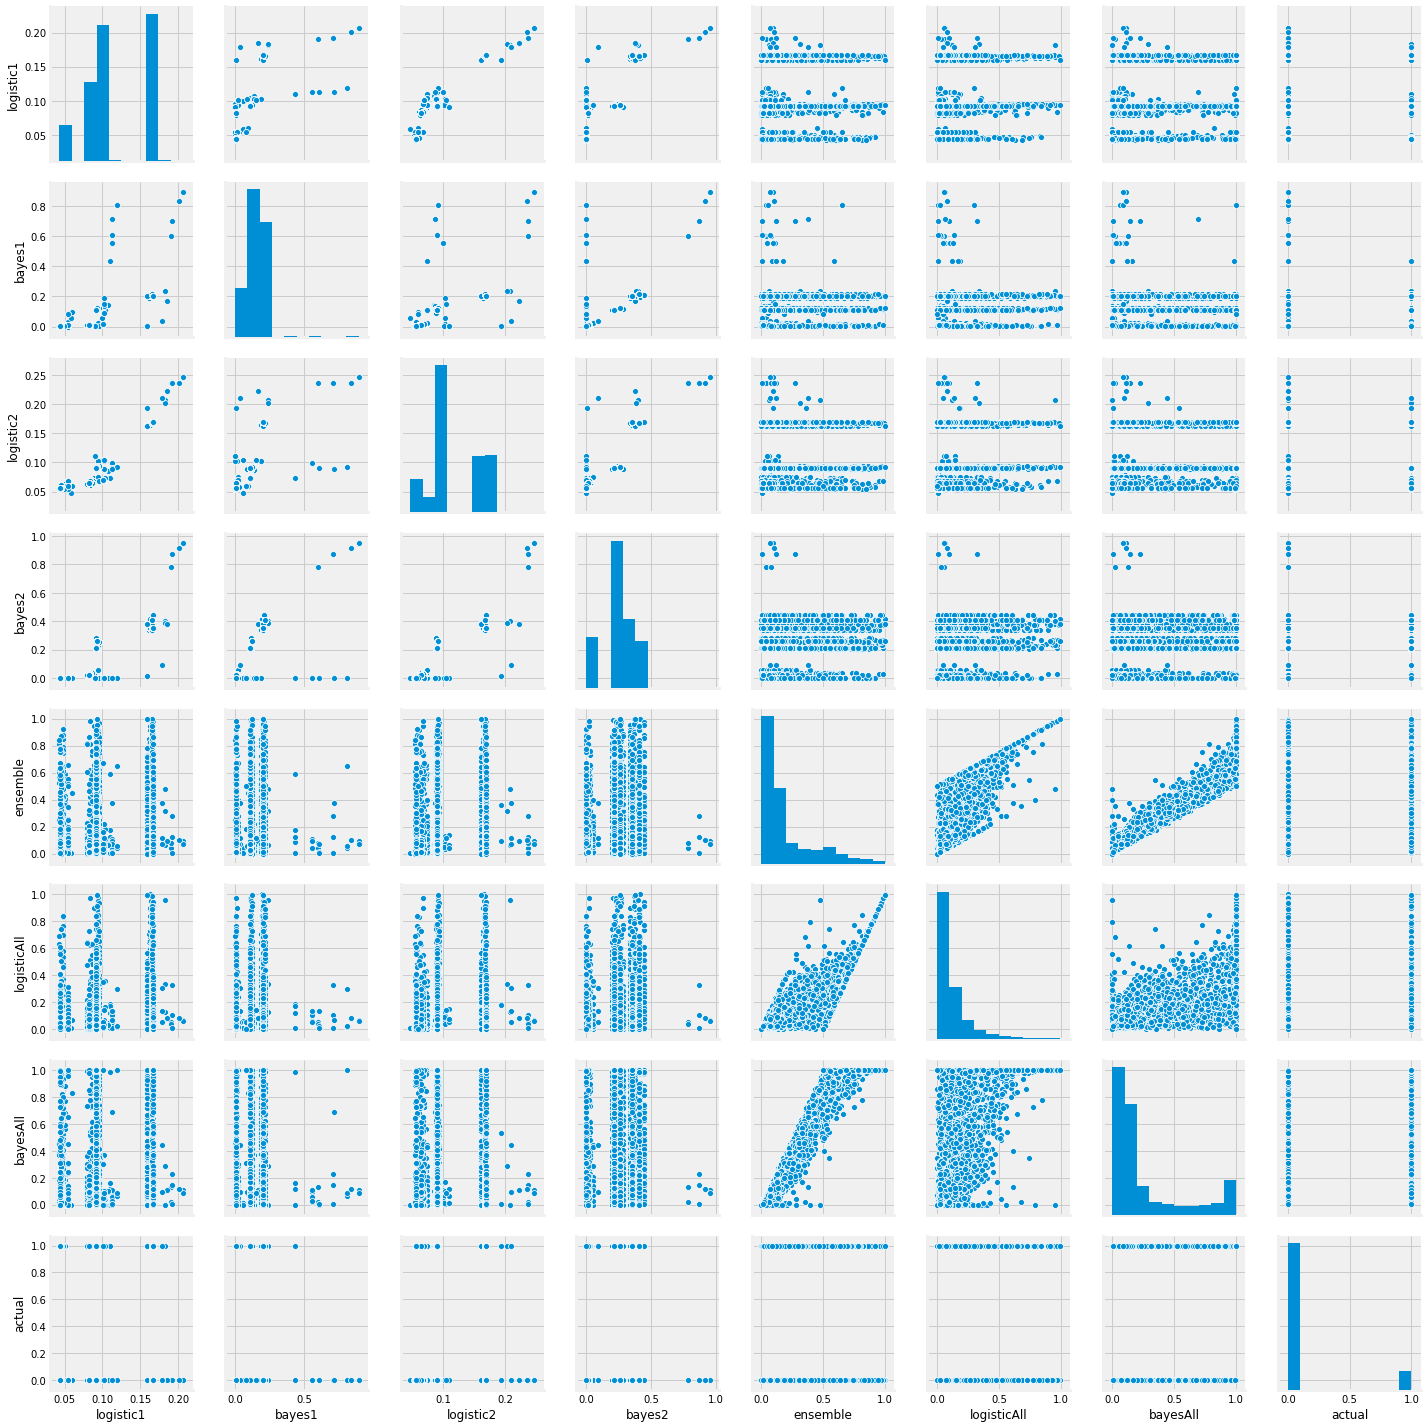

In [28]:
sns.pairplot(predictions)

In [29]:
bank_input = bank_input.join(predictions)

In [30]:
#(df.groupby(['cluster', 'org'], as_index=False).mean()
#            .groupby('cluster')['time'].mean())

bank_input[['loan', 'housing', 'default', 'logistic1', 'bayes1', 'logistic2', 'bayes2', 'logisticAll', 'bayesAll', 'ensemble']].groupby(['loan', 'housing', 'default'], as_index=False).mean()

,loan,housing,default,logistic1,bayes1,logistic2,bayes2,logisticAll,bayesAll,ensemble
0,0,0,0,0.164130,0.202385,0.166698,3.780682e-01,0.143958,0.260002,0.201980
1,0,0,1,0.185883,0.407083,0.221744,5.208941e-01,0.181898,0.141093,0.161496
2,0,1,0,0.093386,0.115179,0.091325,2.381922e-01,0.116223,0.265181,0.190702
3,0,1,1,0.106962,0.322982,0.083022,3.516950e-13,0.085722,0.175646,0.130684
4,1,0,0,0.086007,0.012676,0.067719,2.975531e-02,0.119816,0.227059,0.173438
5,1,0,1,0.096897,0.048241,0.093200,2.138566e-13,0.102274,0.094072,0.098173
6,1,1,0,0.047156,0.006659,0.060498,1.330197e-04,0.104576,0.253403,0.178990
7,1,1,1,0.054591,0.036633,0.058720,2.116736e-30,0.038677,0.210037,0.124357


## Conclusion

Using only the features loan, housing, and default without engineered features the model that performs the best is the logistic regression which has a .608 auc using 10 fold cross validation compared to a .602 auc for the naive bayes model.  With engineered features the auc decreases to .605 for the logistic regression and increases to .605 for the naive bayes model.  When using all of the features plus engineered features the auc jumps to .796 for the logistic regression and .800 for the naive bayes model.  An ensemble of the two models yields a further increase in auc to .820 using the 10 fold cross validated out of fold predictions.  Based on these results the ensemble is clearly the bst model however if management is looking to only use the 3 variables listed then the logistic regression model is best, without engineered features.  

The group that the models using only loan, housing, and default identifies as the best target for direct marketing efforts is the group that doesn't have a loan, doesn't have a housing loan, but does have credit in default (the average score is highest for this group).  For the logistic model using all the variables the model identifies the same group but the naive bayes model identifies the group with no loan, a housing loan, and no credit in default as the best target for direct marketing efforts.  The ensemble identifies the group with no loan, no housing loan, and no default as the best group for direct marketing efforts.  Based on the cross validated results the ensemble is best and so the group identified by that model is ideal for direct marketing efforts. 